In [1]:
# First, import data into R.
library(tidyverse)
library(tidymodels)
install.packages("kknn")
library("kknn")
set.seed(1)
heart_data <- read_csv("https://raw.githubusercontent.com/L-Wendi/dsci-100-project/main/heart.csv")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
heart_data <- heart_data |>
    mutate(sex = fct_recode(as_factor(sex), "Male" = "1", "Female" = "0")) |>
    mutate(exang = fct_recode(as_factor(exang), "Yes" = "1", "No" = "0")) |>
    mutate(target = fct_recode(as_factor(target), "No Disease" = "0", "Disease" = "1"))

In [3]:
heart_split <- initial_split(heart_data, prop = 0.75, strata = exang)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)
heart_predictors_info <- heart_training |>
    select(exang, trestbps, chol) |>
    group_by(exang) |>
    summarize(count = n(),
              mean_trestbps = mean(trestbps), max_trestbps = max(trestbps), min_trestbps = min(trestbps),
              mean_chol = mean(chol), max_chol = max(chol), min_chol = min(chol))

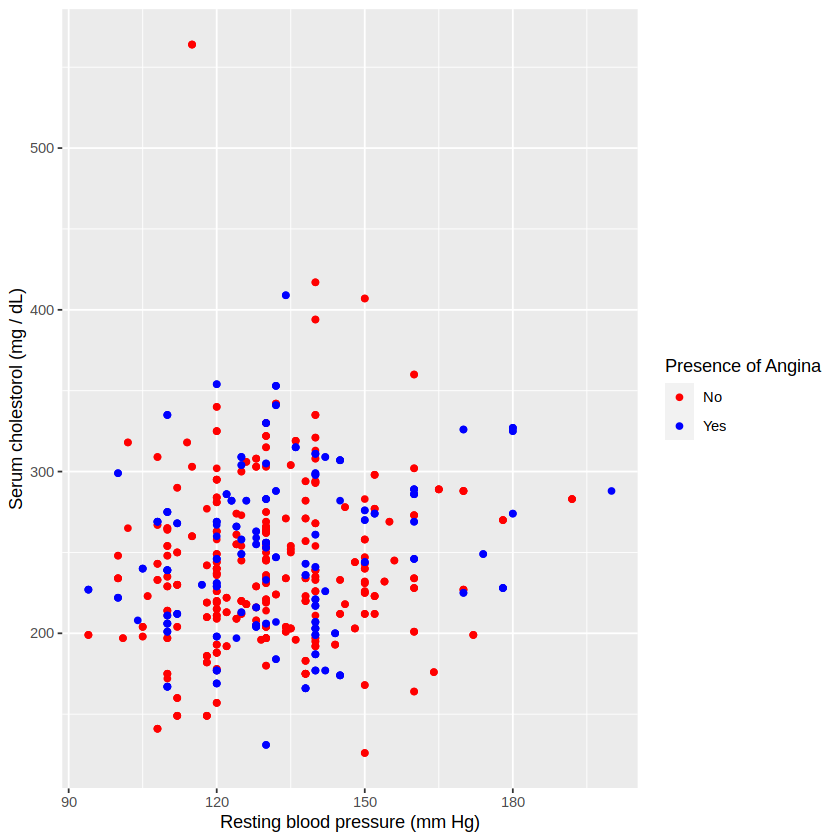

In [4]:
scatter_plot <- heart_training |> ggplot(aes(x = trestbps, y = chol, color = exang)) +
    geom_point() +
    labs(x = "Resting blood pressure (mm Hg)", y = "Serum cholestorol (mg / dL)", color = "Presence of Angina") +
    scale_color_manual(values = c("red", "blue"))
scatter_plot

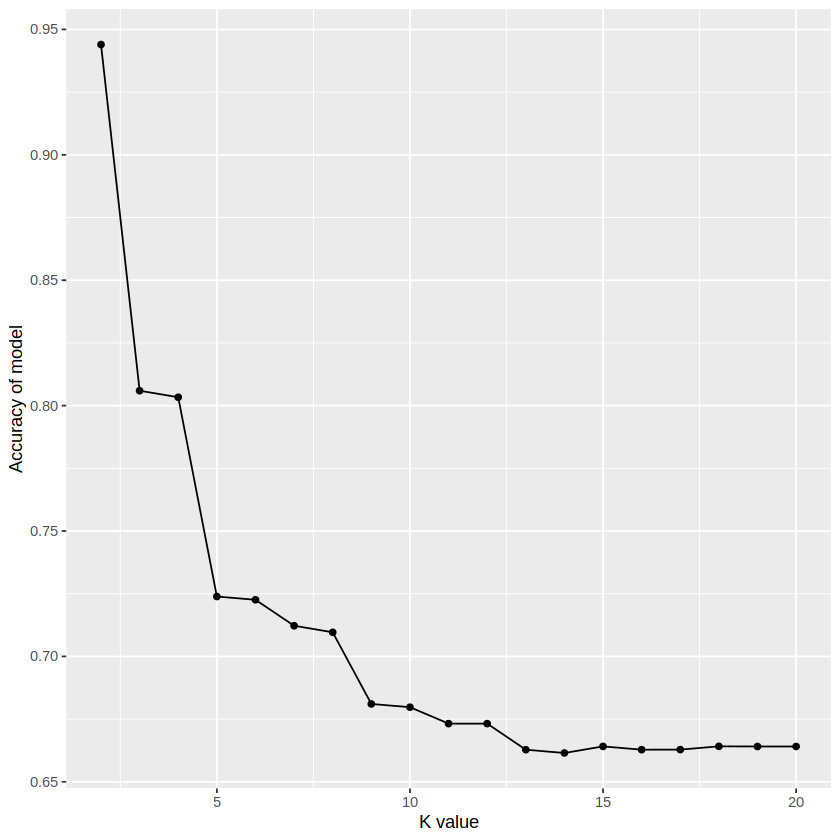

In [5]:
heart_recipe <- recipe(exang ~ trestbps + chol, data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
vfold <- vfold_cv(heart_training, v = 5, strata = exang)
gridvals <- tibble(neighbors = seq(from = 2, to = 20))
wkflw <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = vfold, grid = gridvals) |>
    collect_metrics() 
results <- wkflw |>
    filter(.metric == "accuracy")
k_plot <- results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K value", y = "Accuracy of model")
k_plot

In [6]:
knn_3_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification") 
heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_3_spec) |>
    fit(data = heart_training)

In [7]:
heart_predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)
heart_metrics <- heart_predictions |>
    metrics(truth = exang, estimate = .pred_class) |>
    filter(.metric == "accuracy")
heart_metrics
model_accuracy <- pull(heart_metrics, .estimate)
model_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8638132


[1] 0.8638132

In [8]:
heart_conf_mat <- heart_predictions |>
    conf_mat(truth = exang, estimate = .pred_class)
heart_conf_mat
model_precision <- 66 / (14 + 66)
model_precision
model_recall <- 66 / (21 + 66)
model_recall

          Truth
Prediction  No Yes
       No  156  21
       Yes  14  66

[1] 0.825

[1] 0.7586207